In [14]:
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation

class VRPAgent(Agent):
    def __init__(self, unique_id, model, coordonnees_clients, coordonnees_depots, T_max, T_min, alpha, max_iterations):
        super().__init__(unique_id, model)
        self.coordonnees_clients = coordonnees_clients
        self.coordonnees_depots = coordonnees_depots
        self.T_max = T_max
        self.T_min = T_min
        self.alpha = alpha
        self.max_iterations = max_iterations
        self.solution = None

    def distance(self, coord1, coord2):
        lat1, lon1 = coord1
        lat2, lon2 = coord2
        radius = 6371  # Rayon de la Terre en kilomètres
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = radius * c
        return distance

    def distance_totale(self, solution):
        total_distance = 0
        for route in solution:
            if len(route) > 0:
                total_distance += self.distance(self.coordonnees_depots[0], self.coordonnees_clients[route[0]])  # distance du dépôt au premier client
                for i in range(len(route) - 1):
                    total_distance += self.distance(self.coordonnees_clients[route[i]], self.coordonnees_clients[route[i + 1]])  # distance entre les clients dans la route
                total_distance += self.distance(self.coordonnees_clients[route[-1]], self.coordonnees_depots[0])  # distance du dernier client au dépôt
        return total_distance

    def generer_solution_initiale(self):
        return [[random.randint(0, len(self.coordonnees_clients) - 1) for _ in range(random.randint(1, len(self.coordonnees_clients)))] for _ in range(len(self.coordonnees_clients))]

class VRPModel(Model):
    def __init__(self, nombre_agents, coordonnees_clients, coordonnees_depots, T_max, T_min, alpha, max_iterations):
        super().__init__()
        self.nombre_agents = nombre_agents
        self.coordonnees_clients = coordonnees_clients
        self.coordonnees_depots = coordonnees_depots
        self.T_max = T_max
        self.T_min = T_min
        self.alpha = alpha
        self.max_iterations = max_iterations
        self._steps = 0
        self._time = 0

        self.schedule = RandomActivation(self)
        for i in range(self.nombre_agents):
            agent = VRPAgent(i, self, coordonnees_clients, coordonnees_depots, T_max, T_min, alpha, max_iterations)
            self.schedule.add(agent)

    def step(self):
        self.schedule.step()
        self._steps += 1  # Incrémenter le nombre d'étapes à chaque pas de simulation
        self._time += 1  # Incrémenter le temps à chaque pas de simulation

# Fonction pour calculer la distance totale parcourue par les véhicules dans une solution donnée
def distance_totale(solution, coordonnees):
    total_distance = 0
    for route in solution:
        if len(route) > 0:
            total_distance += VRPAgent.distance(coordonnees[0], coordonnees[route[0]])  # distance du dépôt au premier client
            for i in range(len(route) - 1):
                total_distance += VRPAgent.distance(coordonnees[route[i]], coordonnees[route[i + 1]])  # distance entre les clients dans la route
            total_distance += VRPAgent.distance(coordonnees[route[-1]], coordonnees[0])  # distance du dernier client au dépôt
    return total_distance

# Fonction pour sélectionner la meilleure solution parmi toutes les solutions des agents
def selectionner_meilleure_solution(solutions, coordonnees):
    meilleure_solution = None
    meilleure_distance = float('inf')
    for solution in solutions:
        distance_solution = distance_totale(solution, coordonnees)
        if distance_solution < meilleure_distance:
            meilleure_solution = solution
            meilleure_distance = distance_solution
    return meilleure_solution, meilleure_distance

def recuit_simule_vrp_sma(coordonnees_clients, coordonnees_depots, T_max, T_min, alpha, max_iterations, nombre_agents):
    model = VRPModel(nombre_agents, coordonnees_clients, coordonnees_depots, T_max, T_min, alpha, max_iterations)
    convergence_agents = [[] for _ in range(nombre_agents)]  # Liste pour enregistrer la convergence de chaque agent
    meilleure_solution, meilleure_distance = None, float('inf')

    for agent in model.schedule.agents:
        nouvelle_solution = agent.generer_solution_initiale()
        nouvelle_distance = agent.distance_totale(nouvelle_solution)
        if nouvelle_distance < meilleure_distance:
            meilleure_solution = nouvelle_solution
            meilleure_distance = nouvelle_distance

        # Enregistrer la convergence de l'agent
        convergence_agents[agent.unique_id].append(meilleure_distance)

    convergence_globale = [meilleure_distance]
    T = T_max
    for i in range(max_iterations):
        for agent in model.schedule.agents:
            nouvelle_solution = agent.generer_solution_initiale()
            nouvelle_distance = agent.distance_totale(nouvelle_solution)
            delta_distance = nouvelle_distance - meilleure_distance

            if delta_distance < 0 or random.random() < math.exp(-delta_distance / T):
                agent.solution = nouvelle_solution
                meilleure_solution = nouvelle_solution
                meilleure_distance = nouvelle_distance

            # Enregistrer la convergence de l'agent
            convergence_agents[agent.unique_id].append(meilleure_distance)

        convergence_globale.append(meilleure_distance)

        T *= alpha
        if T < T_min:
            break

    return meilleure_solution, meilleure_distance, convergence_agents, convergence_globale




In [15]:
# Fonction pour tracer le graphe de la solution
def tracer_graphe_solution(solution, coordonnees_clients, coordonnees_depots):
    plt.figure(figsize=(8, 6))
    depot_x, depot_y = coordonnees_depots[0]
    plt.plot(depot_x, depot_y, 'ro')  # Marquer le dépôt en rouge
    for route in solution:
        if len(route) > 0:
            route_x = [coordonnees_depots[0][0]] + [coordonnees_clients[client][0] for client in route] + [coordonnees_depots[0][0]]
            route_y = [coordonnees_depots[0][1]] + [coordonnees_clients[client][1] for client in route] + [coordonnees_depots[0][1]]
            plt.plot(route_x, route_y, marker='o')

    plt.title("Graphe de la solution VRP")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

# Fonction pour tracer le graphe de convergence de chaque agent
def tracer_graphe_convergence_agents(convergence_agents):
    plt.figure(figsize=(8, 6))
    for i, convergence in enumerate(convergence_agents):
        plt.plot(convergence, label=f"Agent {i+1}", marker='o')
    plt.title("Graphe de convergence de chaque agent")
    plt.xlabel("Itération")
    plt.ylabel("Distance totale")
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonction pour tracer le graphe de convergence globale
def tracer_graphe_convergence_globale(convergence_globale):
    plt.figure(figsize=(8, 6))
    plt.plot(convergence_globale, marker='o')
    plt.title("Graphe de convergence globale de la solution VRP")
    plt.xlabel("Itération")
    plt.ylabel("Distance totale")
    plt.grid(True)
    plt.show()

# Charger les données des clients et des dépôts à partir des fichiers Excel
df_clients = pd.read_excel('2_detail_table_customers.xls')
df_depots = pd.read_excel('4_detail_table_depots.xls')

# Traitement des données pour obtenir les coordonnées des clients et des dépôts
coordonnees_clients = df_clients[['CUSTOMER_LATITUDE', 'CUSTOMER_LONGITUDE']].values.tolist()
coordonnees_depots = df_depots[['DEPOT_LATITUDE', 'DEPOT_LONGITUDE']].values.tolist()

# Exemple d'utilisation
T_max = 100.0
T_min = 0.1
alpha = 0.9
max_iterations = 1000
nombre_agents = 5

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



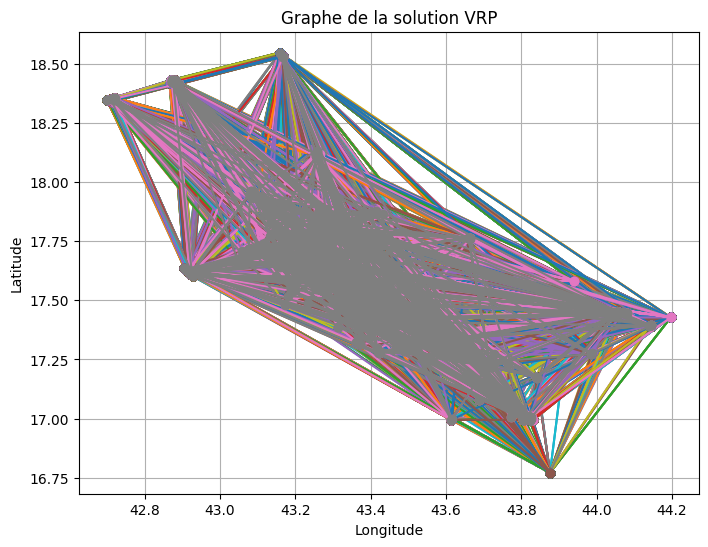

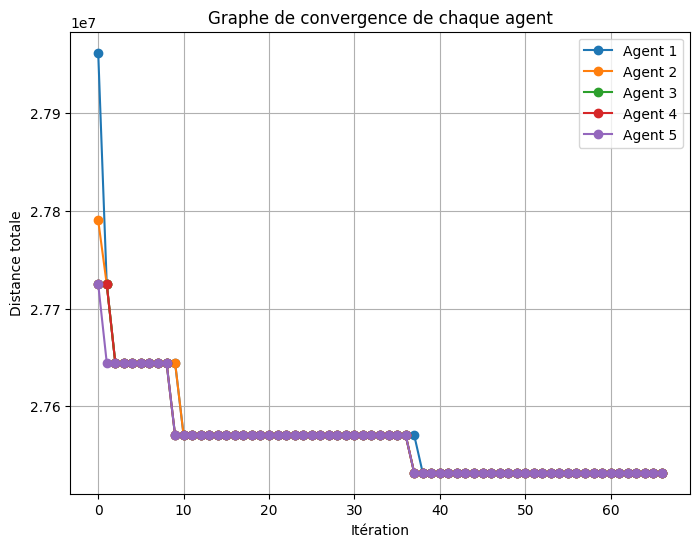

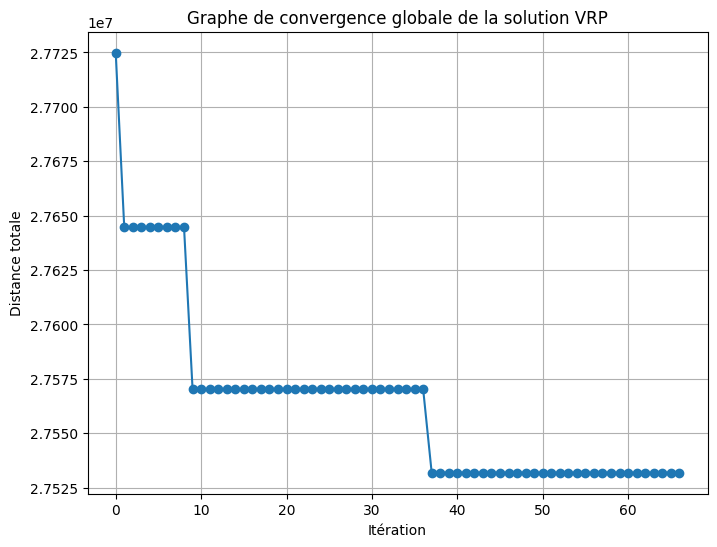

In [16]:

# Appeler votre fonction de résolution du VRP avec vos données
meilleure_solution, meilleure_distance, convergence_agents, convergence_globale = recuit_simule_vrp_sma(coordonnees_clients, coordonnees_depots, T_max, T_min, alpha, max_iterations, nombre_agents)

# Afficher le résultat
print("Meilleure solution VRP (SMA):", meilleure_solution)
print("Distance totale parcourue (SMA):", meilleure_distance)

# Tracer les graphes
tracer_graphe_solution(meilleure_solution, coordonnees_clients, coordonnees_depots)
tracer_graphe_convergence_agents(convergence_agents)
tracer_graphe_convergence_globale(convergence_globale)